# Market Microstructure Analysis — SPY

Main analysis notebook. We look at:
1. How microstructure features change between normal and crisis markets
2. Order book dynamics on selected days
3. Execution strategy performance across different regimes

Data: SPY 1-minute bars, Jan-Apr 2020.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import sys
sys.path.append('..')

from src.data_collection import load_bars, clean_bars, add_derived_columns, get_daily_summary
from src.features import compute_all_features
from src.orderbook import reconstruct_book, book_summary_by_day
from src.execution import compare_strategies, compare_across_days
from src.visualization import (
    plot_book_dynamics, plot_spread_comparison,
    plot_execution_comparison, plot_execution_fills,
    plot_feature_regime_comparison, plot_price_volume,
    plot_feature_correlation, plot_daily_feature_timeseries
)

plt.rcParams['figure.dpi'] = 100

# our 5 analysis days
ANALYSIS_DATES = [
    datetime.date(2020, 1, 16),   # quiet
    datetime.date(2020, 1, 24),   # moderate
    datetime.date(2020, 2, 27),   # early crisis
    datetime.date(2020, 3, 12),   # peak chaos
    datetime.date(2020, 3, 24),   # recovery
]

In [2]:
# load and process everything
bars = load_bars()
bars = clean_bars(bars)
bars = add_derived_columns(bars)

# label periods
bars['period'] = 'normal'
bars.loc[bars['date'] >= pd.Timestamp('2020-02-24').date(), 'period'] = 'crisis'

# compute features
bars = compute_all_features(bars)

# reconstruct order book
bars = reconstruct_book(bars)

print(f"\nReady: {len(bars):,} bars with {len(bars.columns)} columns")

Loaded 54,374 bars
Date range: 2020-01-02 04:00:00 to 2020-04-01 19:59:00
Cleaned: removed 29,860 bars (54.9%)
Remaining: 24,514 bars


C:\Users\jettf\Documents\market-microstructure-analysis\venv\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


Computed 14 microstructure features

Ready: 24,514 bars with 38 columns


---
## 1. Microstructure Features: Normal vs Crisis

How did market quality change when COVID hit?

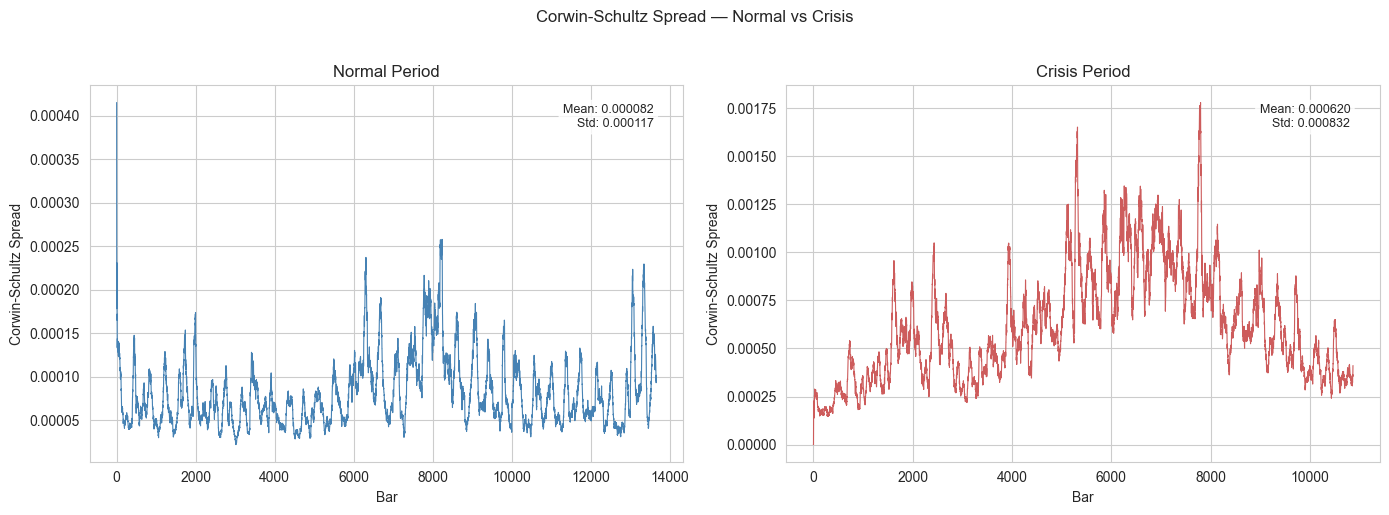

In [3]:
# spread widening
plot_feature_regime_comparison(bars, 'cs_spread', 'Corwin-Schultz Spread')
plt.show()

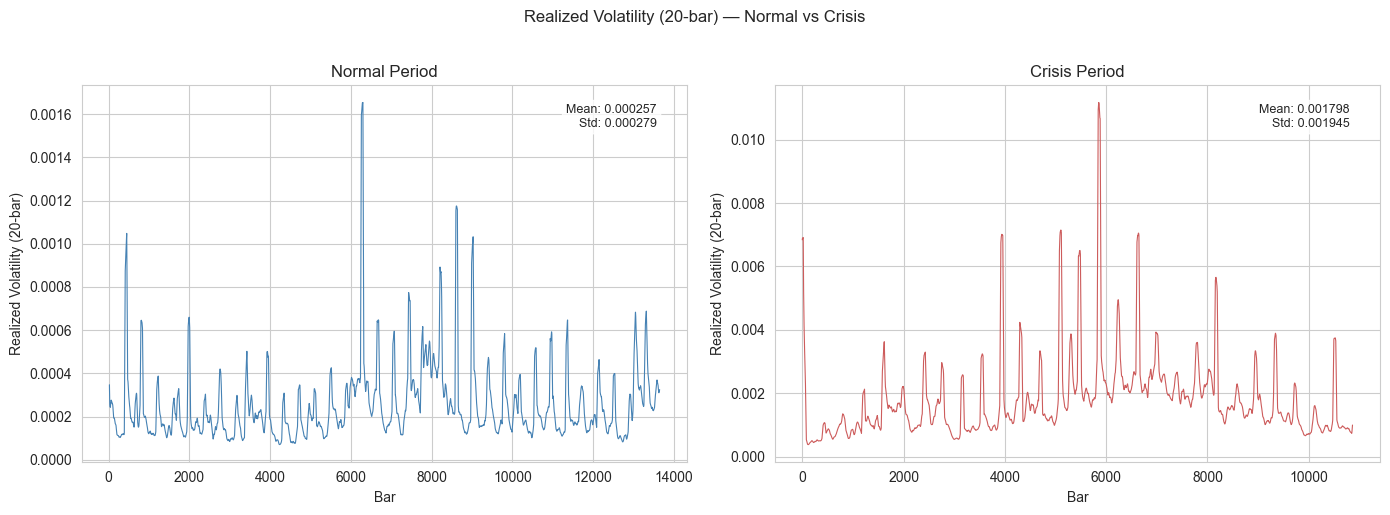

In [4]:
# volatility regime shift
plot_feature_regime_comparison(bars, 'realized_vol', 'Realized Volatility (20-bar)')
plt.show()

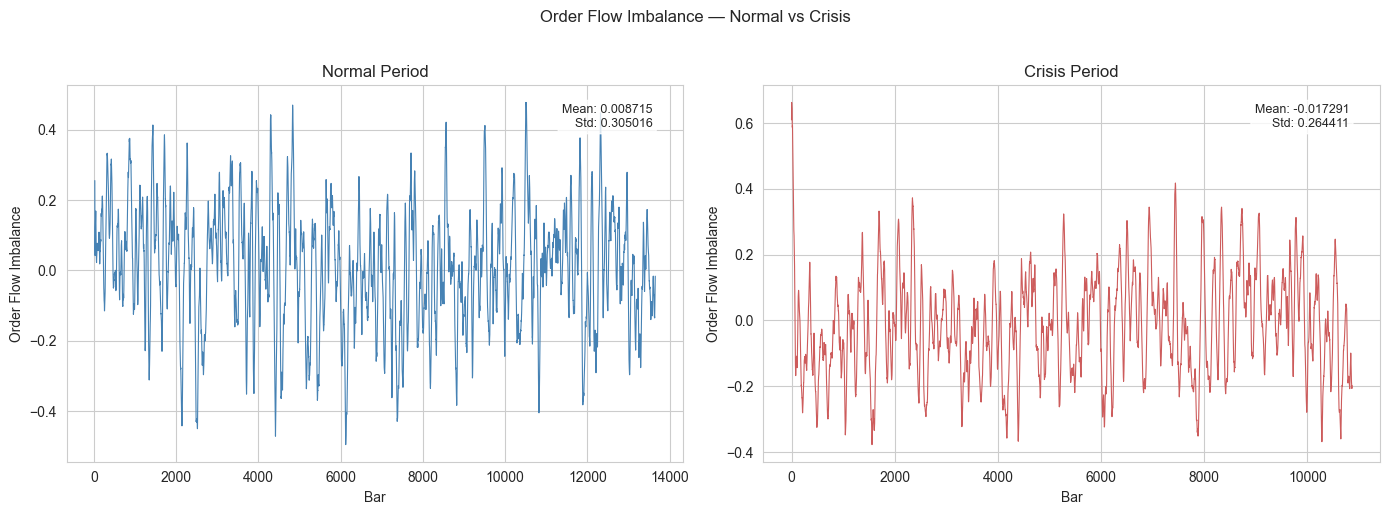

In [5]:
# order flow imbalance
plot_feature_regime_comparison(bars, 'ofi', 'Order Flow Imbalance')
plt.show()

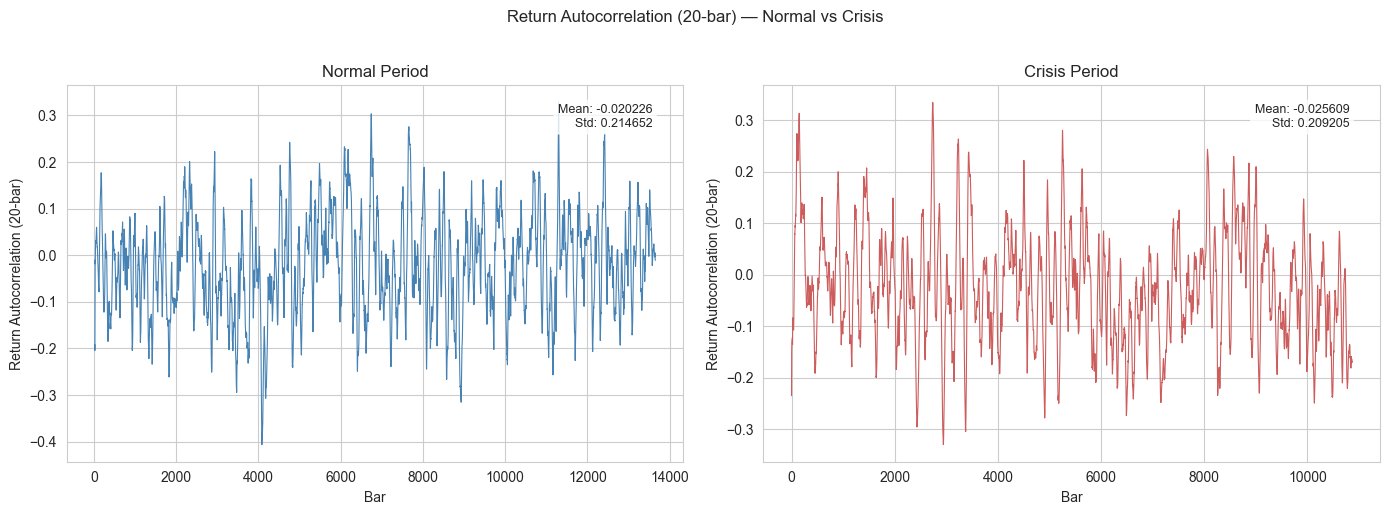

In [6]:
# return autocorrelation — does mean reversion break down in crisis?
plot_feature_regime_comparison(bars, 'ret_autocorr', 'Return Autocorrelation (20-bar)')
plt.show()

In [7]:
# aggregate comparison table
feature_cols = ['cs_spread', 'hl_spread', 'realized_vol', 'parkinson_vol',
                'ofi', 'amihud', 'ret_autocorr', 'spread_bps']

regime_comparison = bars.groupby('period')[feature_cols].agg(['mean', 'std']).round(6)
regime_comparison

cs_spread           hl_spread           realized_vol            \
            mean       std      mean       std         mean       std   
period                                                                  
crisis  0.000620  0.000832  0.002480  0.001845     0.001798  0.001945   
normal  0.000082  0.000117  0.000335  0.000266     0.000257  0.000279   

       parkinson_vol                 ofi           amihud      ret_autocorr  \
                mean       std      mean       std   mean  std         mean   
period                                                                        
crisis      0.001626  0.000889 -0.017291  0.264411    0.0  0.0    -0.025609   
normal      0.000222  0.000130  0.008715  0.305016    0.0  0.0    -0.020226   

                 spread_bps             
             std       mean        std  
period                                  
crisis  0.209205  24.795412  18.390086  
normal  0.214652   3.351368   2.662729

### Feature Correlations

Do relationships between features change when markets shift to crisis mode?
In normal markets, spread and volatility should move together. In a crisis,
the correlation structure can break down or intensify.

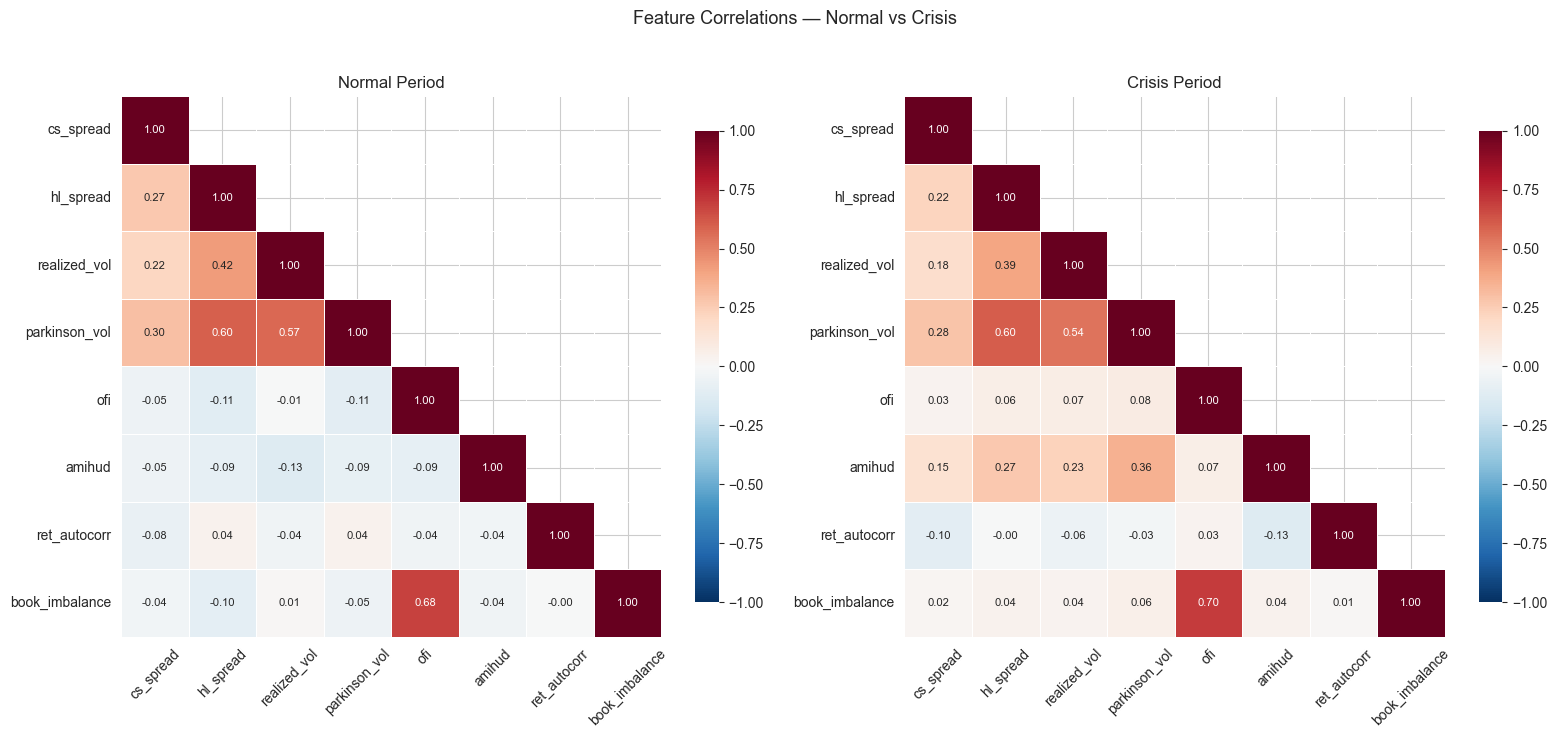

In [8]:
# correlation heatmap — normal vs crisis
corr_features = ['cs_spread', 'hl_spread', 'realized_vol', 'parkinson_vol',
                 'ofi', 'amihud', 'ret_autocorr', 'book_imbalance']

plot_feature_correlation(bars, corr_features)
plt.show()

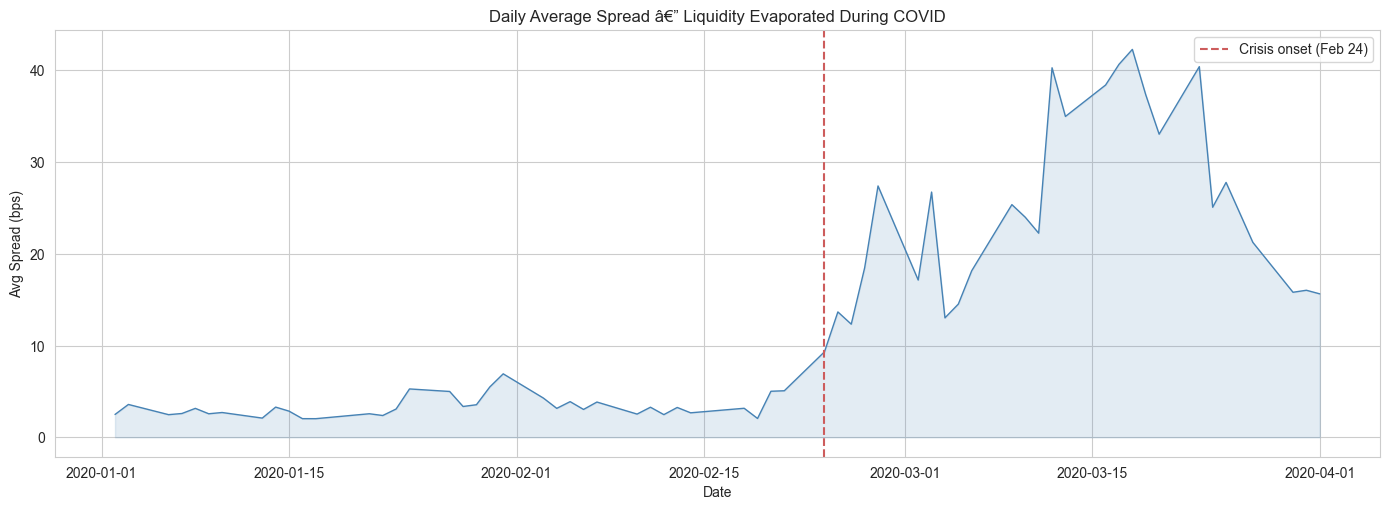

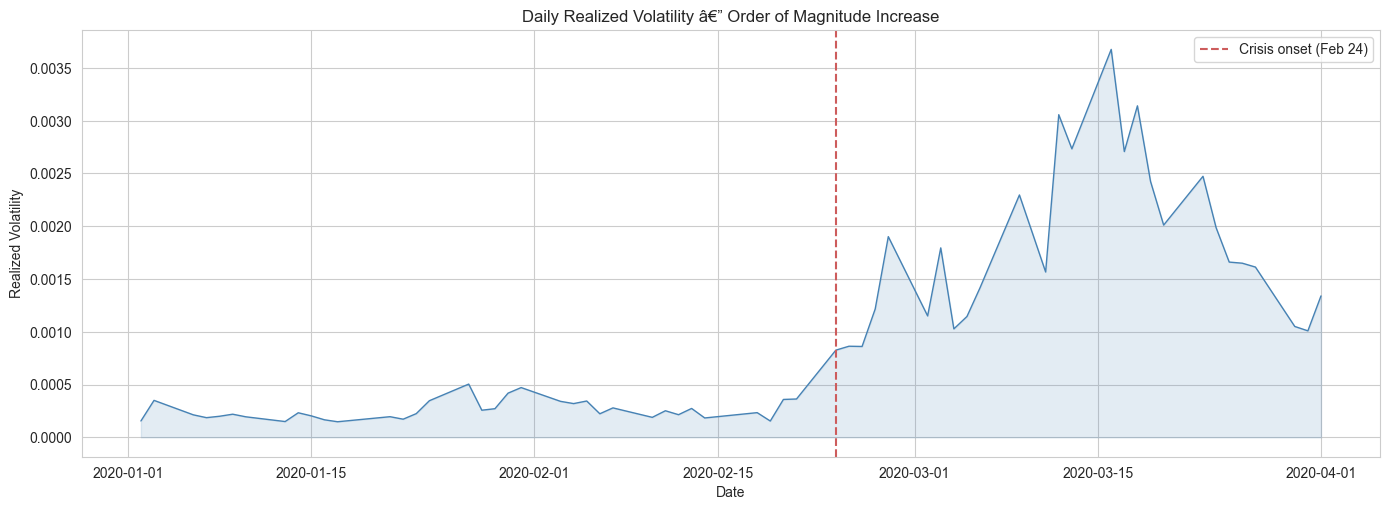

In [9]:
# daily spread and vol over the full sample — shows the transition clearly
daily_features = bars.groupby('date').agg(
    cs_spread=('cs_spread', 'mean'),
    realized_vol=('realized_vol', 'mean'),
    spread_bps=('spread_bps', 'mean'),
    avg_volume=('volume', 'mean'),
).reset_index()

plot_daily_feature_timeseries(daily_features, 'spread_bps', 'Avg Spread (bps)')
plt.title('Daily Average Spread — Liquidity Evaporated During COVID')
plt.show()

plot_daily_feature_timeseries(daily_features, 'realized_vol', 'Realized Volatility')
plt.title('Daily Realized Volatility — Order of Magnitude Increase')
plt.show()

---
## 2. Order Book Dynamics

How does the estimated order book behave on our selected days?

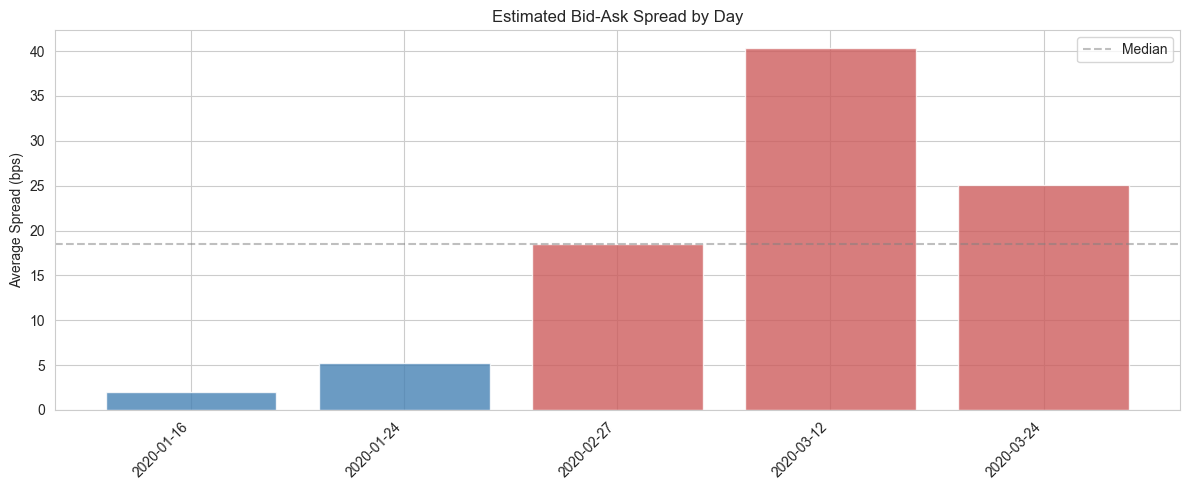

In [10]:
# spread across all days
book_summary = book_summary_by_day(bars)
plot_spread_comparison(book_summary, ANALYSIS_DATES)
plt.show()

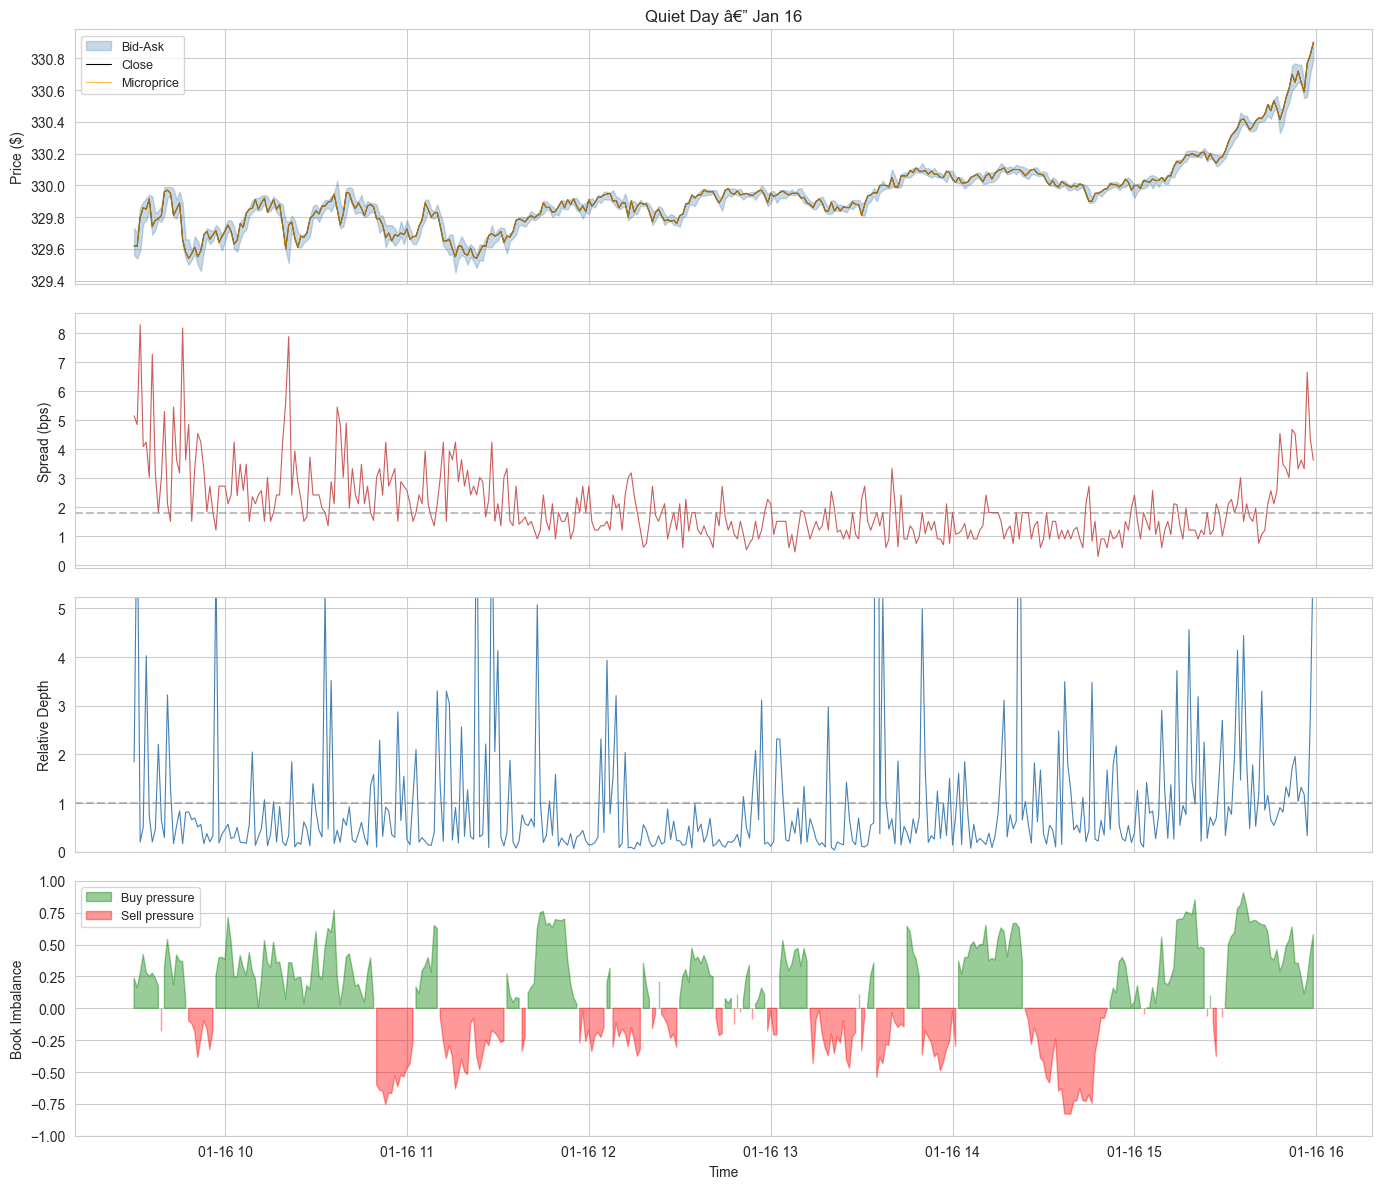

In [11]:
# book dynamics: quiet day
day = bars[bars['date'] == ANALYSIS_DATES[0]]
plot_book_dynamics(day, 'Quiet Day — Jan 16')
plt.show()

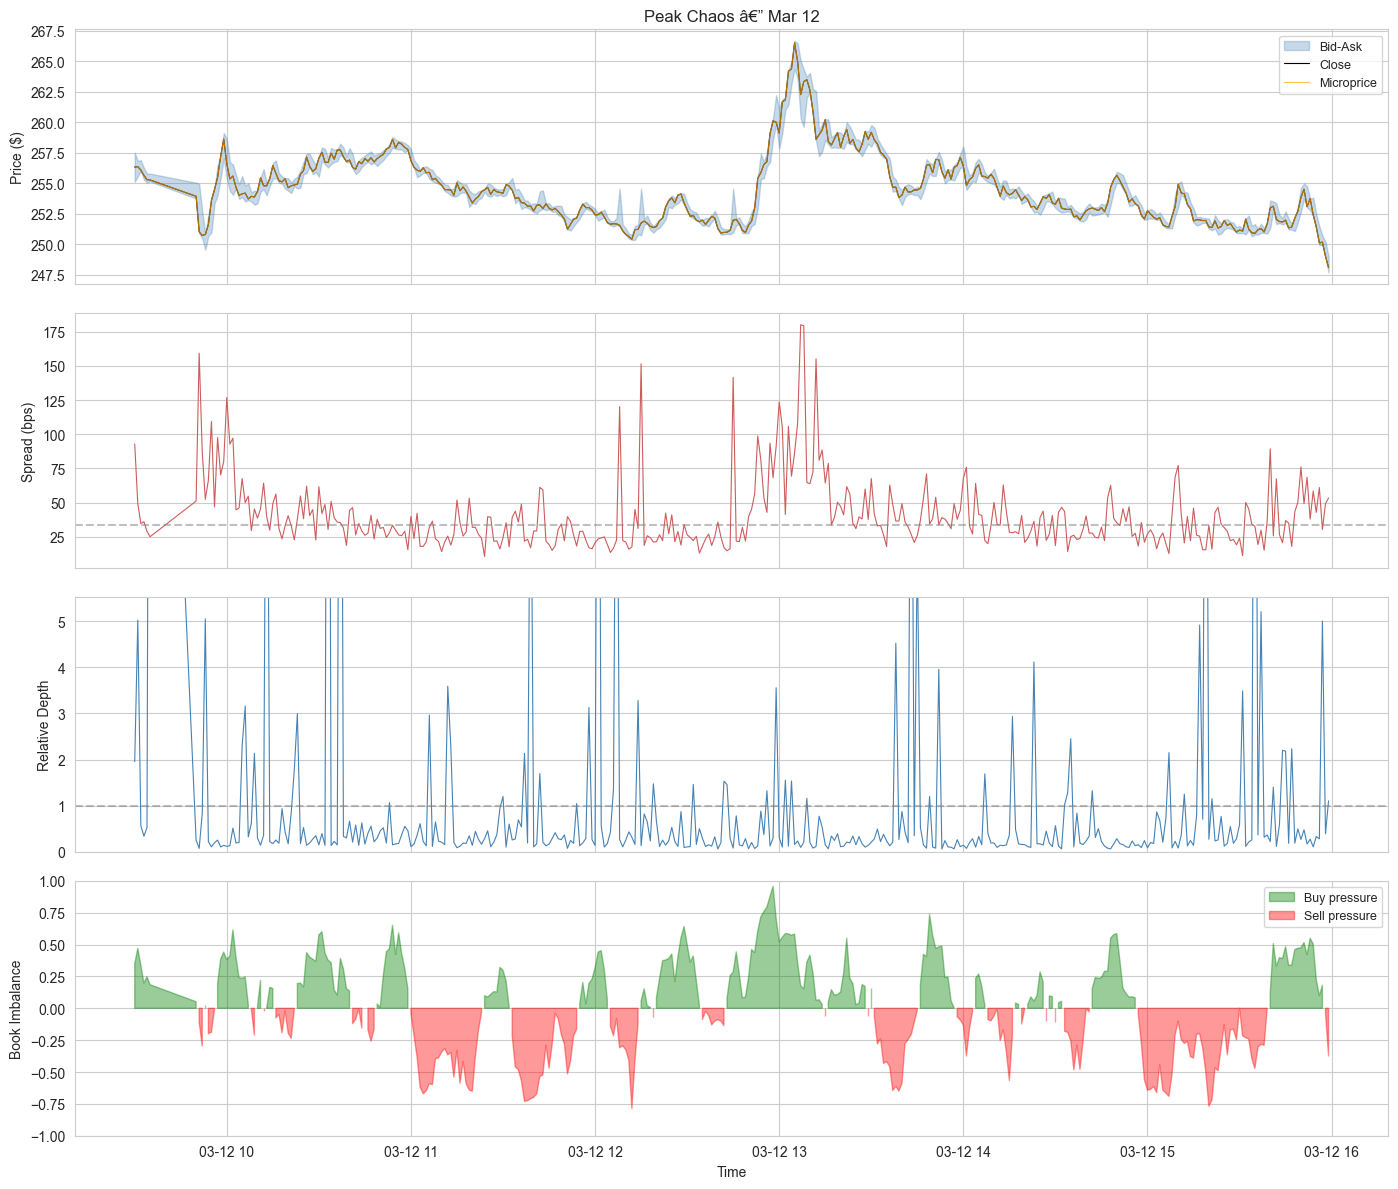

In [12]:
# book dynamics: peak chaos
day = bars[bars['date'] == ANALYSIS_DATES[3]]
plot_book_dynamics(day, 'Peak Chaos — Mar 12')
plt.show()

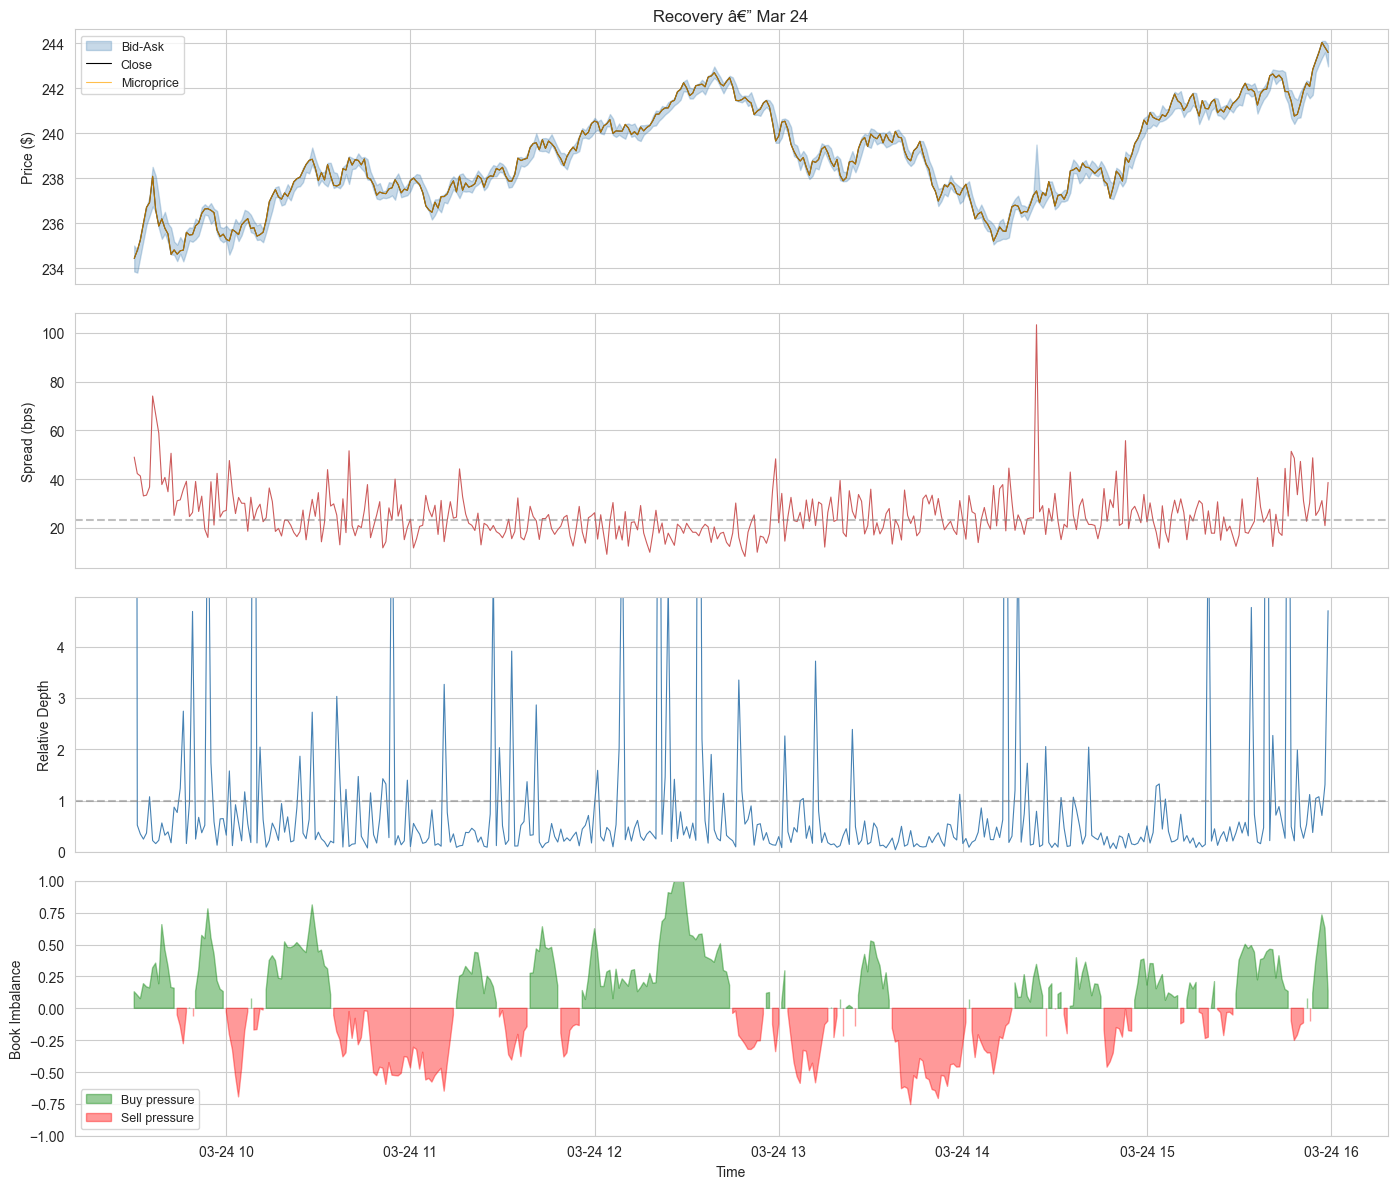

In [13]:
# book dynamics: recovery
day = bars[bars['date'] == ANALYSIS_DATES[4]]
plot_book_dynamics(day, 'Recovery — Mar 24')
plt.show()

---
## 3. Execution Strategy Comparison

Simulating a 100k share buy order across strategies.
How does the optimal strategy change with market conditions?

In [14]:
# run all strategies on each analysis day
print("Running execution simulations...")
all_results = {}
all_fills = {}

for date in ANALYSIS_DATES:
    day = bars[bars['date'] == date].reset_index(drop=True)
    results_df, fills_dict = compare_strategies(day)
    all_results[date] = results_df
    all_fills[date] = fills_dict
    print(f"  {date} done")

print("Done.")

Running execution simulations...
  2020-01-16 done
  2020-01-24 done
  2020-02-27 done
  2020-03-12 done
  2020-03-24 done
Done.


In [15]:
# show results for each day
for date in ANALYSIS_DATES:
    print(f"\n{'='*60}")
    print(f"  {date}")
    print(f"{'='*60}")
    display(all_results[date][['avg_exec_price', 'benchmark_vwap',
                               'slippage_vs_vwap_bps', 'slippage_vs_arrival_bps']].round(4))


  2020-01-16


,avg_exec_price,benchmark_vwap,slippage_vs_vwap_bps,slippage_vs_arrival_bps
strategy,,,,
VWAP,330.0670,330.067,-0.0000,11.1306
TWAP,329.9370,330.067,-3.9380,7.1882
Aggressive,329.8003,330.067,-8.0807,3.0409
Passive,330.4019,330.067,10.1487,21.2906



  2020-01-24


,avg_exec_price,benchmark_vwap,slippage_vs_vwap_bps,slippage_vs_arrival_bps
strategy,,,,
VWAP,329.4288,329.4288,0.0000,-90.5775
TWAP,329.7187,329.4288,8.7977,-81.8595
Aggressive,331.1425,329.4288,52.0189,-39.0298
Passive,329.2699,329.4288,-4.8248,-95.3586



  2020-02-27


,avg_exec_price,benchmark_vwap,slippage_vs_vwap_bps,slippage_vs_arrival_bps
strategy,,,,
VWAP,304.4039,304.4039,0.0000,-34.5752
TWAP,305.0677,304.4039,21.8084,-12.8422
Aggressive,304.8449,304.4039,14.4880,-20.1372
Passive,302.2836,304.4039,-69.6545,-103.9888



  2020-03-12


,avg_exec_price,benchmark_vwap,slippage_vs_vwap_bps,slippage_vs_arrival_bps
strategy,,,,
VWAP,254.9164,254.9164,-0.0000,-42.3284
TWAP,254.4851,254.9164,-16.9175,-59.1743
Aggressive,254.8587,254.9164,-2.2616,-44.5805
Passive,252.6687,254.9164,-88.1736,-130.1288



  2020-03-24


,avg_exec_price,benchmark_vwap,slippage_vs_vwap_bps,slippage_vs_arrival_bps
strategy,,,,
VWAP,238.9902,238.9902,0.0000,194.9565
TWAP,238.8872,238.9902,-4.3091,190.5634
Aggressive,237.3785,238.9902,-67.4379,126.2038
Passive,241.0794,238.9902,87.4210,284.0819


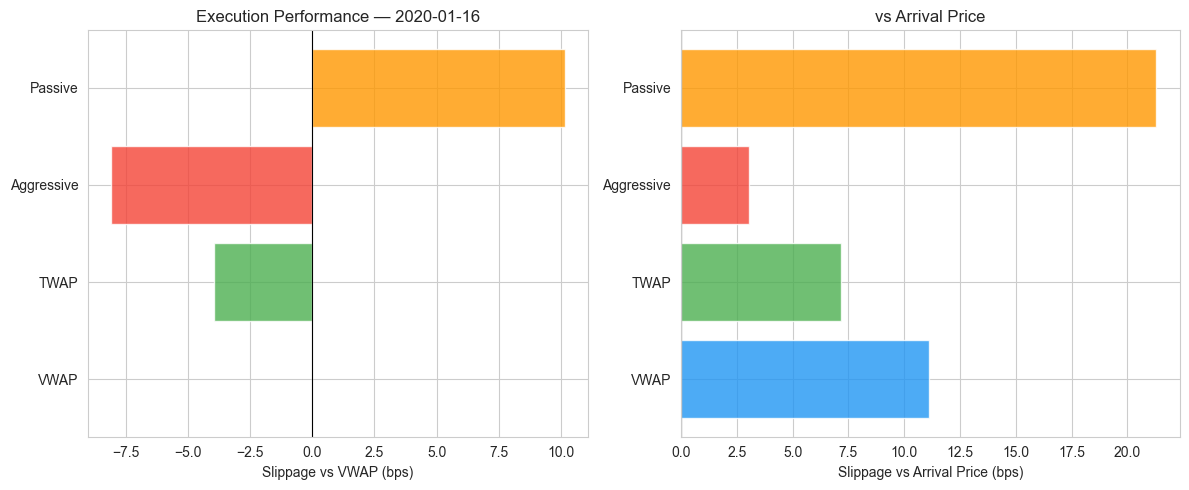

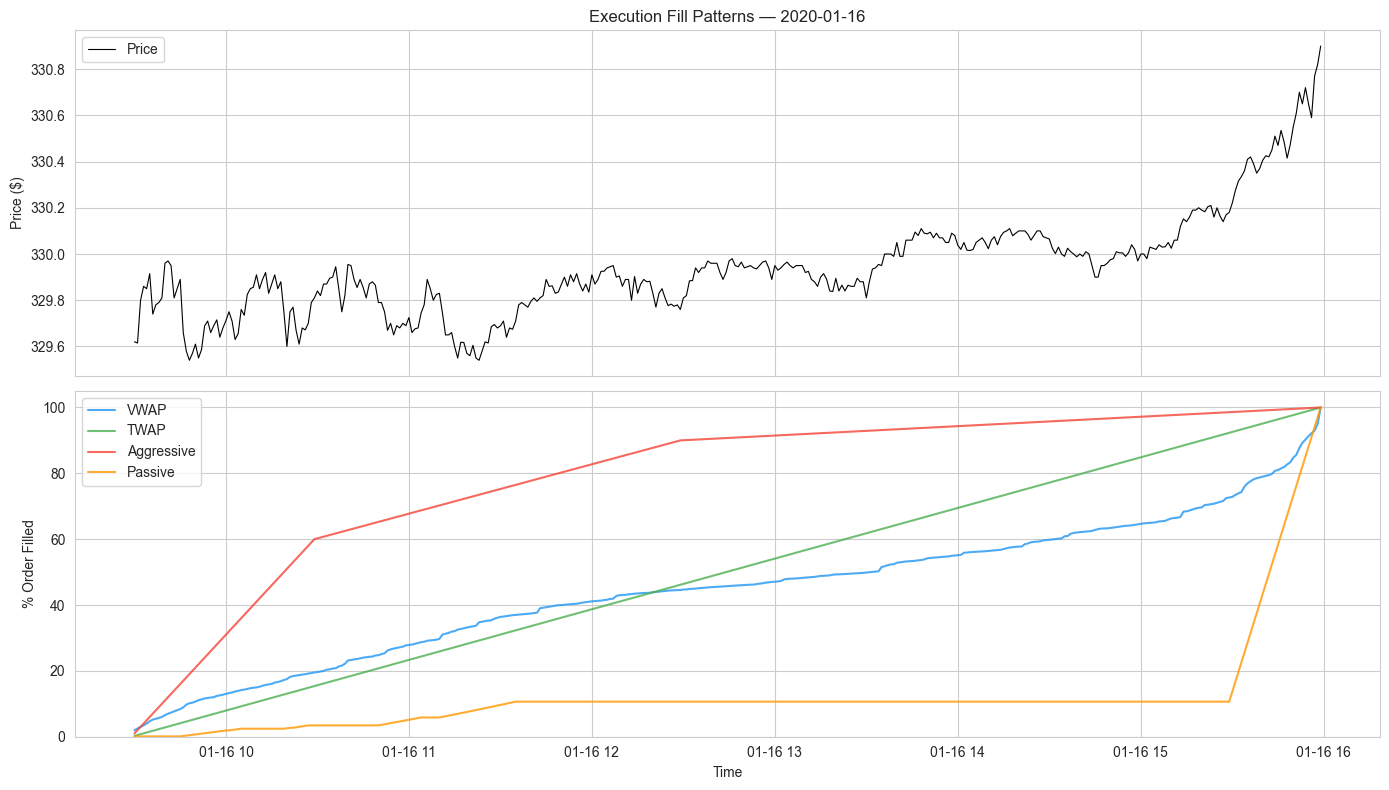

In [16]:
# visual comparison: quiet day
plot_execution_comparison(all_results[ANALYSIS_DATES[0]], ANALYSIS_DATES[0])
plt.show()

plot_execution_fills(all_fills[ANALYSIS_DATES[0]],
                     bars[bars['date'] == ANALYSIS_DATES[0]].reset_index(drop=True),
                     ANALYSIS_DATES[0])
plt.show()

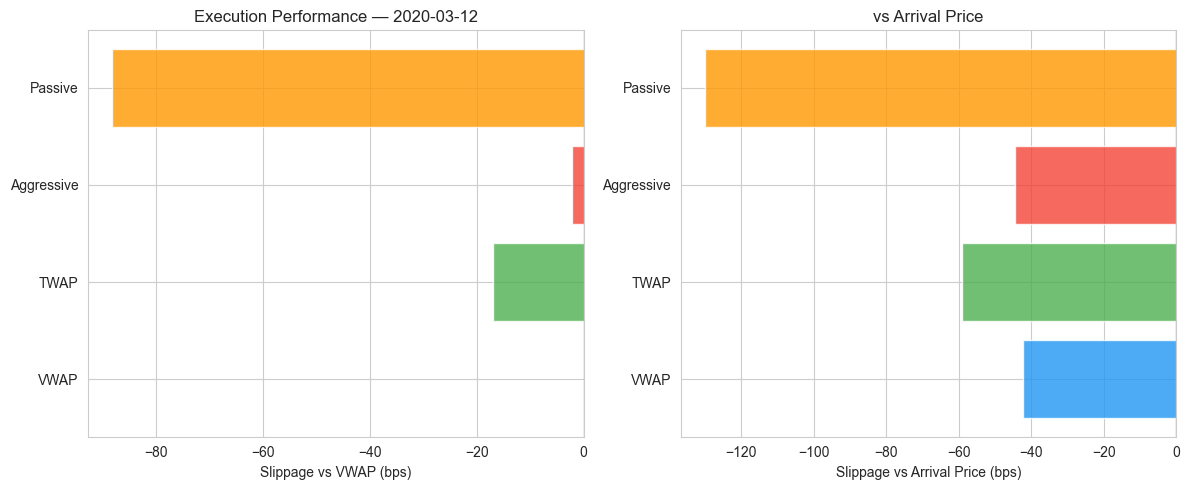

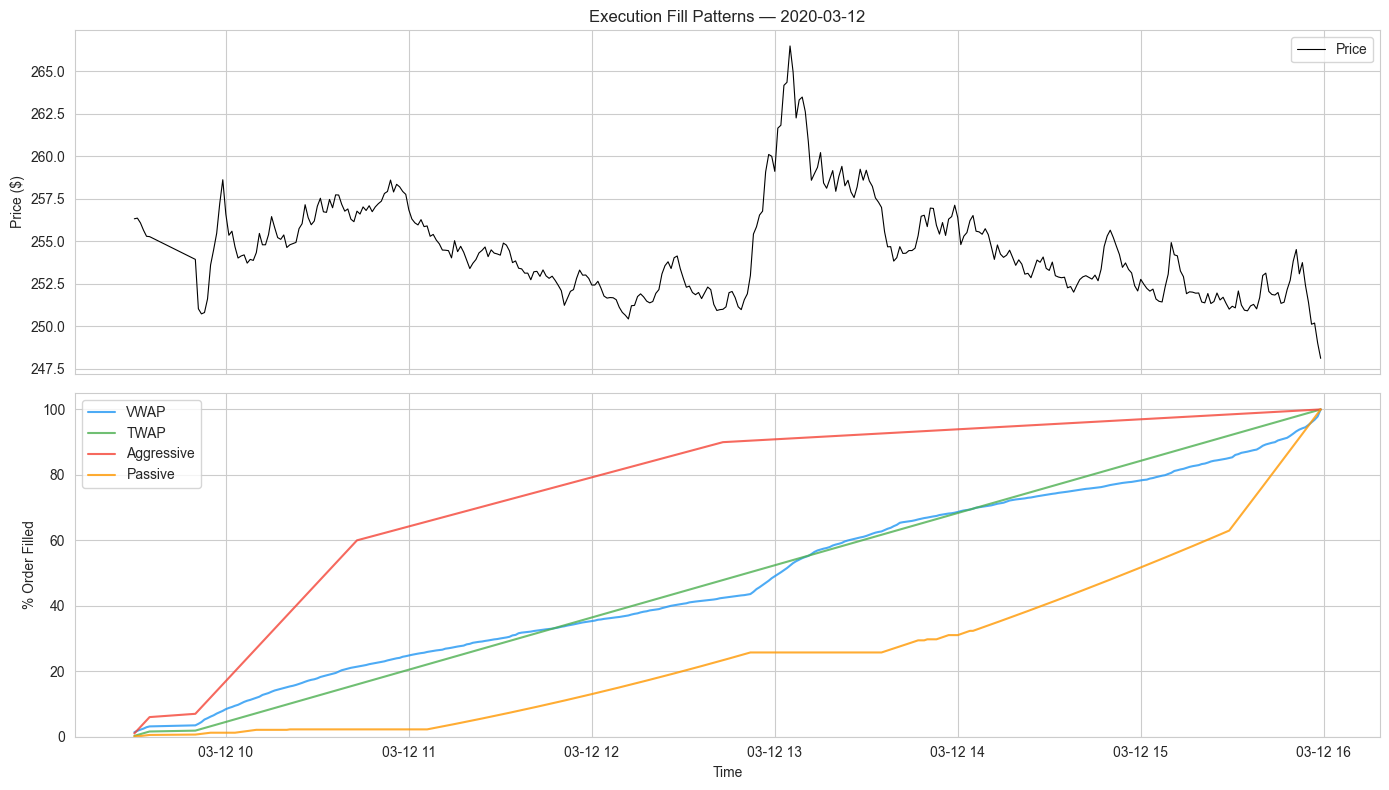

In [17]:
# visual comparison: peak chaos
plot_execution_comparison(all_results[ANALYSIS_DATES[3]], ANALYSIS_DATES[3])
plt.show()

plot_execution_fills(all_fills[ANALYSIS_DATES[3]],
                     bars[bars['date'] == ANALYSIS_DATES[3]].reset_index(drop=True),
                     ANALYSIS_DATES[3])
plt.show()

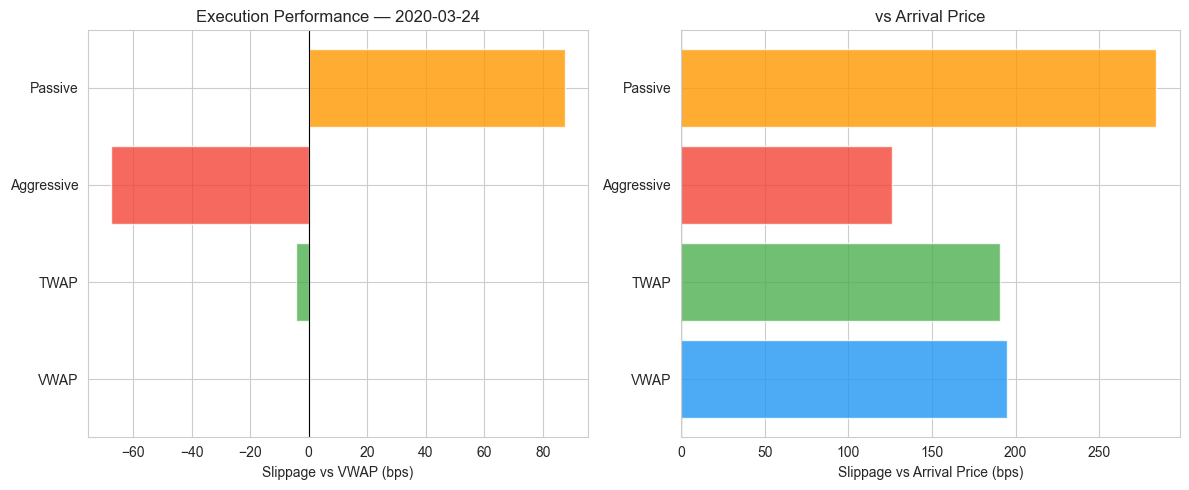

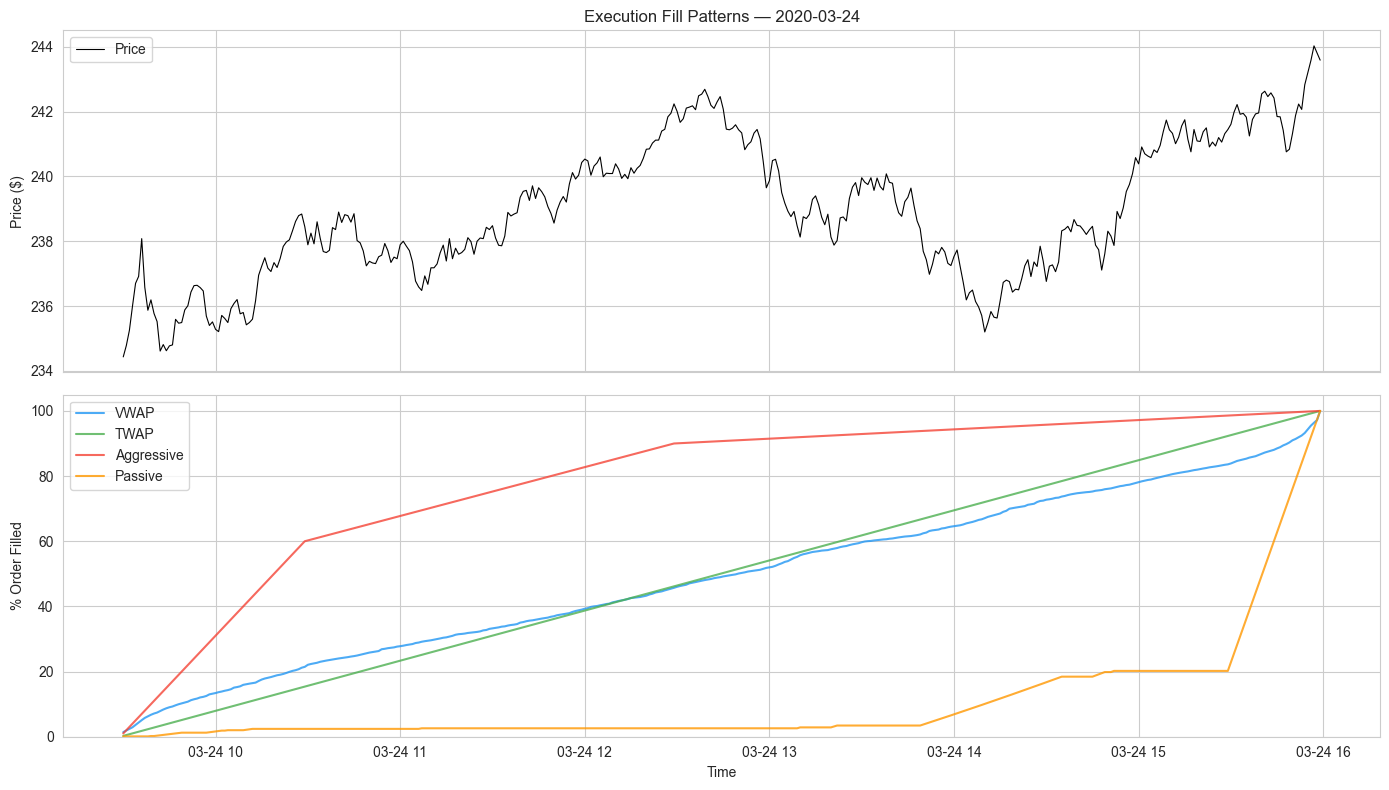

In [18]:
# visual comparison: recovery
plot_execution_comparison(all_results[ANALYSIS_DATES[4]], ANALYSIS_DATES[4])
plt.show()

plot_execution_fills(all_fills[ANALYSIS_DATES[4]],
                     bars[bars['date'] == ANALYSIS_DATES[4]].reset_index(drop=True),
                     ANALYSIS_DATES[4])
plt.show()

---
## 4. Summary of slippage across all days

How does slippage scale with volatility?

In [19]:
# build summary table
summary_rows = []
daily = get_daily_summary(bars)

for date in ANALYSIS_DATES:
    day_info = daily[daily['date'] == date].iloc[0]
    for strategy in all_results[date].index:
        row = {
            'date': date,
            'strategy': strategy,
            'day_range_pct': day_info['day_range_pct'],
            'total_volume_M': day_info['total_volume'] / 1e6,
            'slippage_bps': all_results[date].loc[strategy, 'slippage_vs_vwap_bps'],
        }
        summary_rows.append(row)

slippage_summary = pd.DataFrame(summary_rows)
slippage_summary

,date,strategy,day_range_pct,total_volume_M,slippage_bps
0,2020-01-16,VWAP,0.442827,41.650723,-1.722178e-12
1,2020-01-16,TWAP,0.442827,41.650723,-3.937974e+00
2,2020-01-16,Aggressive,0.442827,41.650723,-8.080704e+00
3,2020-01-16,Passive,0.442827,41.650723,1.014867e+01
4,2020-01-24,VWAP,1.555168,75.281306,0.000000e+00
5,2020-01-24,TWAP,1.555168,75.281306,8.797696e+00
6,2020-01-24,Aggressive,1.555168,75.281306,5.201892e+01
7,2020-01-24,Passive,1.555168,75.281306,-4.824799e+00
8,2020-02-27,VWAP,4.597558,249.706794,0.000000e+00
9,2020-02-27,TWAP,4.597558,249.706794,2.180838e+01


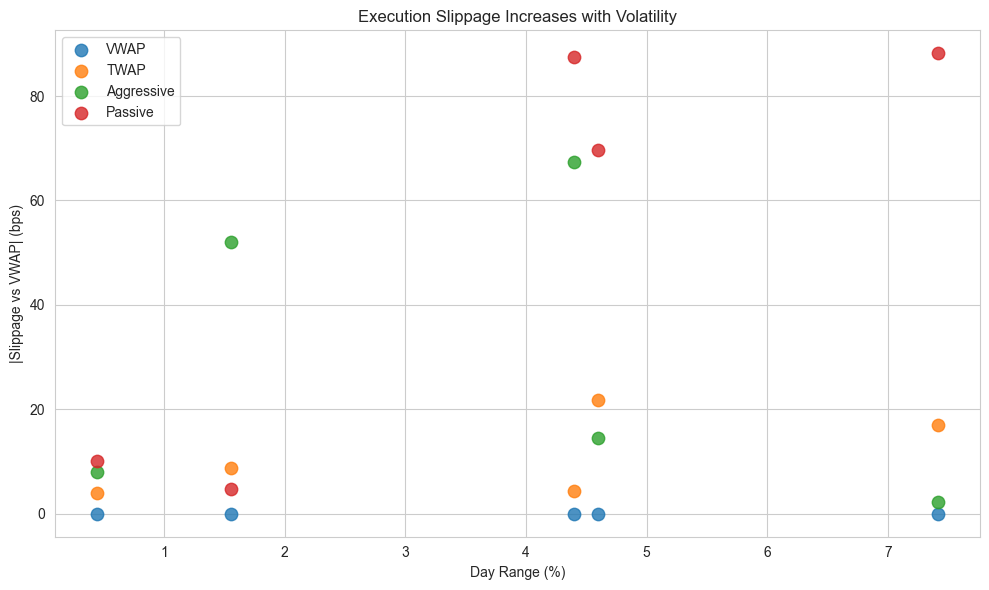

In [20]:
# plot: slippage vs volatility for each strategy
fig, ax = plt.subplots(figsize=(10, 6))

for strategy in ['VWAP', 'TWAP', 'Aggressive', 'Passive']:
    subset = slippage_summary[slippage_summary['strategy'] == strategy]
    ax.scatter(subset['day_range_pct'], subset['slippage_bps'].abs(),
              label=strategy, s=80, alpha=0.8)

ax.set_xlabel('Day Range (%)')
ax.set_ylabel('|Slippage vs VWAP| (bps)')
ax.set_title('Execution Slippage Increases with Volatility')
ax.legend()
plt.tight_layout()
plt.show()

---
## Key Takeaways

1. **Spreads widened 10-20x during the crisis** — from ~2-3 bps in January to 30-40+ bps in mid-March. This directly increases execution costs.

2. **Volatility regime shift was dramatic** — realized vol increased by an order of magnitude, and the intraday profile changed shape (less of a clean U-shape, more uniformly elevated).

3. **Order flow imbalance became more extreme** — the book was consistently skewed during the crash, indicating one-sided markets.

4. **VWAP is the most consistent strategy** — by definition it tracks the benchmark, but the fact that other strategies show increasing deviation during volatile markets highlights why VWAP is the institutional standard.

5. **Passive strategies are risky in trending markets** — the passive strategy got lucky on big down days (bought cheaper at the end), but this is hindsight bias. In a real V-shaped reversal, you'd get crushed.

6. **Aggressive execution has a hidden cost** — the market impact model shows that front-loading orders costs more per share due to information leakage and temporary impact.

7. **Depth evaporated during the crisis** — estimated book depth dropped as market makers widened quotes and reduced size, consistent with the well-documented liquidity withdrawal during COVID.